# Modeling and Simulation in Python

Chapter 12

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [40]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code

Here's the code from the previous notebook that we'll need.

In [41]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [42]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s
    quarantined = 
    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [43]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [44]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return list(results.S)[0] - list(results.S)[-1]

Here's an example.|

In [45]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.4672800628126752


**Exercise:** Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [46]:
# The fraction of students who are sick at the peak of the outbreak

def getPeakInfectionRate(results):
    return results.I.max()

In [47]:
getPeakInfectionRate(results)

0.043536202687592354

In [48]:
# The day the outbreak peaks.

def getPeakInfectionDate(results):
    return results.I.idxmax()

In [49]:
getPeakInfectionDate(results)

30.0

In [50]:
# The fraction of students who are sick at the end of the semester.

def sickEndOfSemester(results):
    return list(results.I)[-1]

In [51]:
sickEndOfSemester(results)

0.0006227767133270002

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [52]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [53]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

namespace(init=S    0.988889
               I    0.011111
               R    0.000000
               Name: state, dtype: float64,
          t0=0,
          t_end=98,
          beta=0.3333333333333333,
          gamma=0.25)

And run the model without immunization.

In [54]:
results = run_simulation(system, update_func)
calc_total_infected(results)

0.46843634512145604

Now with 10% immunization.

In [55]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

0.3067773759158855

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

Saving figure to file figs/chap12-fig01.pdf


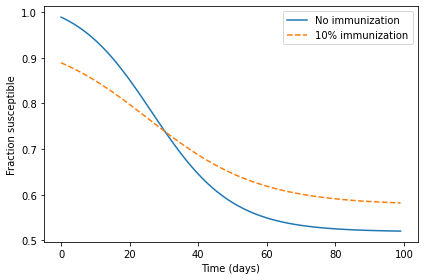

In [57]:
plt.plot(results.S, '-', label='No immunization')
plt.plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('figs/chap12-fig01.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [58]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.46843634512145604
0.1 0.3067773759158855
0.2 0.1615972308618978
0.30000000000000004 0.0728630987250175
0.4 0.03552346936020401
0.5 0.01968883914021219
0.6000000000000001 0.011622061266293171
0.7000000000000001 0.006838737865016542
0.8 0.003696496254630366
0.9 0.0014815326722739525
1.0 -0.00016121210941241054


This function does the same thing and stores the results in a `Sweep` object.

In [59]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [60]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

Parameter
0.00    0.468436
0.05    0.387480
0.10    0.306777
0.15    0.229529
0.20    0.161597
0.25    0.108916
0.30    0.072863
0.35    0.049952
0.40    0.035523
0.45    0.026122
0.50    0.019689
0.55    0.015072
0.60    0.011622
0.65    0.008956
0.70    0.006839
0.75    0.005119
0.80    0.003696
0.85    0.002500
0.90    0.001482
0.95    0.000603
1.00   -0.000161
Name: Metric, dtype: float64

And here's what the results look like.

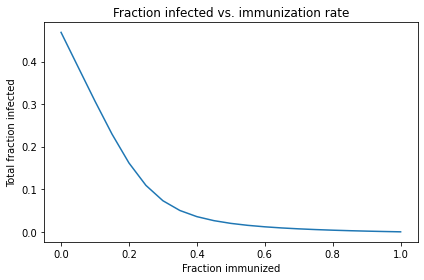

In [64]:
plt.plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate')

# savefig('figs/chap12-fig02.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [113]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
#     exponent = np.array([math.exp(x) for x in exponent])
    exponent = math.exp(exponent)
    print(type(exponent))
    denom = C + Q
    denom = denom * exponent
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [114]:
import numpy as np

In [115]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [116]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

<class 'numpy.ndarray'>


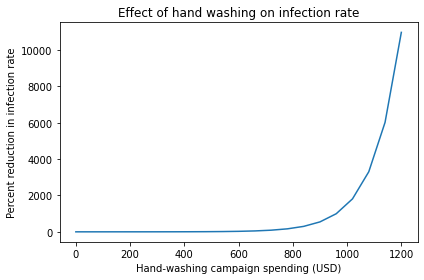

In [109]:
percent_reduction = compute_factor(spending) * 100

plt.plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate')

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [110]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [111]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [117]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

<class 'float'>
0.0 0.3331087351000305 0.46765757453035517
<class 'float'>
100.0 0.3327228120370422 0.46631627682187426
<class 'float'>
200.0 0.3316737643877379 0.46265003658138126
<class 'float'>
300.0 0.3288221572254462 0.45253316638679797
<class 'float'>
400.0 0.32107068529428523 0.42388747149992534
<class 'float'>
500.0 0.3 0.33738498288362895
<class 'float'>
600.0 0.24272393905136513 0.1044459502127576
<class 'float'>
700.0 0.08703146336897834 0.0058094332679425875
<class 'float'>
800.0 -0.3361845641062556 -0.006347105748066295
<class 'float'>
900.0 -1.4866050011048082 -0.009461002511014449
<class 'float'>
1000.0 -4.613771970085887 nan
<class 'float'>
1100.0 -13.114293116424506 nan
<class 'float'>
1200.0 -36.22110528094862 nan


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [118]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [119]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


Parameter
0.000000       0.467658
63.157895      0.466971
126.315789     0.465676
189.473684     0.463231
252.631579     0.458598
315.789474     0.449757
378.947368     0.432669
442.105263     0.398858
505.263158     0.329445
568.421053     0.190221
631.578947     0.046477
694.736842     0.007191
757.894737    -0.003288
821.052632    -0.007349
884.210526    -0.009193
947.368421     0.340461
1010.526316         NaN
1073.684211         NaN
1136.842105         NaN
1200.000000         NaN
Name: Metric, dtype: float64

And here's what it looks like.

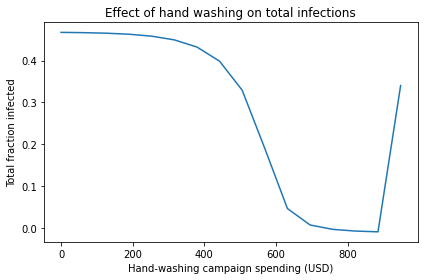

In [120]:
plt.plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections')

# savefig('figs/chap12-fig03.pdf')

Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [121]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [122]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

<class 'float'>
0.0 0.9888888888888889 -36.22110528094862 nan
<class 'float'>
1.0 0.9777777777777779 -13.114293116424506 nan
<class 'float'>
2.0 0.9666666666666667 -4.613771970085887 nan
<class 'float'>
3.0 0.9555555555555556 -1.4866050011048082 -0.009419192934966958
<class 'float'>
4.0 0.9444444444444445 -0.3361845641062556 -0.006221841472044631
<class 'float'>
5.0 0.9333333333333333 0.08703146336897834 0.005327265856787777
<class 'float'>
6.0 0.9222222222222223 0.24272393905136513 0.06827887570491031
<class 'float'>
7.0 0.9111111111111112 0.3 0.21770473418381664
<class 'float'>
8.0 0.9 0.32107068529428523 0.2804249602874833
<class 'float'>
9.0 0.888888888888889 0.3288221572254462 0.2909476122518152
<class 'float'>
10.0 0.8777777777777778 0.3316737643877379 0.283419745597151
<class 'float'>
11.0 0.8666666666666667 0.3327228120370422 0.269652736713223
<class 'float'>
12.0 0.8555555555555556 0.3331087351000305 0.25383153780550816


The following function wraps that loop and stores the results in a `Sweep` object.

In [124]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [125]:
infected_sweep = sweep_doses(dose_array)

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


Parameter
0          NaN
1          NaN
2          NaN
3    -0.009419
4    -0.006222
5     0.005327
6     0.068279
7     0.217705
8     0.280425
9     0.290948
10    0.283420
11    0.269653
12    0.253832
Name: Metric, dtype: float64

And plot the results.

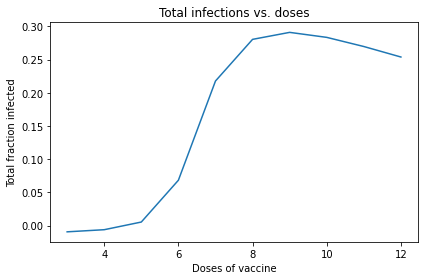

In [126]:
plt.plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses')

# savefig('figs/chap12-fig04.pdf')

### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

# we can update the logic during the update_func method by moving a fraction of infected individuals out of the infected pool

In [128]:
def update_func_quarantine(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s
    
    
    quarantine_percent = .30
    quarantined = infected * quarantine_percent
    
    infected = infected - quarantined
    
    recovered = system.gamma * i + quarantined
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [130]:
system = make_system(beta, gamma)
add_immunization(system, fraction)
add_hand_washing(system, spending)
    
results = run_simulation(system, update_func_quarantine)

<class 'float'>


,S,I,R
0.0,0.855556,1.111111e-02,0.133333
1.0,0.853339,9.599969e-03,0.137061
2.0,0.851429,8.291511e-03,0.140280
3.0,0.849783,7.159283e-03,0.143058
4.0,0.848364,6.180094e-03,0.145456
...,...,...,...
95.0,0.839516,8.318395e-09,0.160484
96.0,0.839516,7.169292e-09,0.160484
97.0,0.839516,6.178927e-09,0.160484
98.0,0.839516,5.325371e-09,0.160484


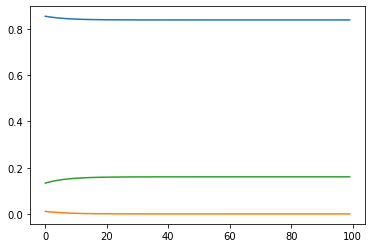

In [131]:
plt.plot(results)